# First pass calculation of the flux from mu decays

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import DarkNews as dn

# Our module
import nuflux

## Test 1


Let's run a simple test to recover the muon decay at rest case. We set Emin and Emax to be essentially = to m_mu.

We should recover the Michel spectrum and a slightly less energetic nu_mubar component.

In [3]:
mudecay_atrest = nuflux.fluxMC.MuonDecay()

df = mudecay_atrest.simulate_decays(
                            pmin = 0, #minimum momentum
                            pmax = 0.001,  #maximum momentum
                            beam_p0 = 0, # average momentum
                            beam_dpop = 0, # no beam spread
                            Rpm=0.5, #Fraction of total muons that are plus (or minus?)
                            NINT=10, #for MC integration
                            NINT_warmup=10,
                            NEVAL=1e5,
                            NEVAL_warmup=1e4,
                            )
_ = mudecay_atrest.propagate_to_detector(
                            ZBEAMEND=250e2, # Length of beam cm
                            ZBEAMEXIT=0, # cm
                            R_ND=[0,0,250e2+50e2], # cm
                            )
_ = mudecay_atrest.flux_in_detector(acceptance=False)

Detector acceptance: 4.1516354527304e-05  for nue, and 5.661130675866581e-05 for numu.


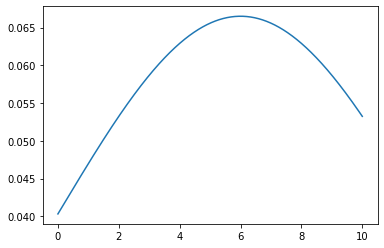

In [54]:
pmin = 0
pmax = 10
mu = 6
sigma = 1 *mu
x = np.linspace(pmin, pmax, 1000)
plt.plot(x, 1 / (sigma * np.sqrt(2*np.pi)) *np.exp(-1/2 * (x-mu)**2 / sigma**2))

In [34]:
Emu = np.linspace(0, 10, 20)
spreads = np.linspace(0,1, 5)
#mu =[3.8]
acceptances =np.zeros((5,2, 20))
for j, R in enumerate(Rpms):
    for i,E0 in enumerate(Emu):
        mudecay_beam = nuflux.fluxMC.MuonDecay()

        df = mudecay_beam.simulate_decays(
                            pmin = 0,
                            pmax = 10,
                            beam_p0 = E0,
                            beam_dpop = spreads[j],
                            Rpm=0.5,
                            NINT=10,
                            NINT_warmup=10,
                            NEVAL=1e5,
                            NEVAL_warmup=1e4,
                            )
        _=mudecay_beam.propagate_to_detector(
                            ZBEAMEND=250e2, # cm
                            ZBEAMEXIT=0, # cm
                            R_ND=[0,0,250e2+50e2], # cm
                            )
        a,b = mudecay_beam.flux_in_detector(acceptance = True)
        print(a,b)
        acceptances[j][0][i] = a
        acceptances[j][1][i] = b

0.4299362756086159 0.43110472970540537
0.43009451985936253 0.43031994404093415
0.43079004197117765 0.4298694726470312
0.4312362717808692 0.4301481246241571
0.4309908221161204 0.4305176617414824
0.43117558654139193 0.4310813822986249
0.43165095626770167 0.43264605857460026
0.430916481691726 0.4306409308015178
0.43062440443301747 0.43039673990388977
0.4303278948245994 0.43076868232934923
0.4317956014141199 0.4305120576571529
0.4324415807856951 0.43071479136862995
0.4305734288044443 0.4310219491511334
0.4305754974925055 0.43092455449443307
0.4303914160581633 0.4310161048119556
0.4312782715624098 0.4294234381781915
0.4309223774912904 0.43040738790450683
0.4303887866259202 0.430389851744753
0.4301063265860734 0.43111690138566744
0.42969614419435287 0.431261771587763
0.43011123161974507 0.429890283368328
0.01824410139254935 0.0181098375456262
0.06516937455526528 0.06497063195232314
0.125100716561869 0.12368627450235126
0.1867095097995249 0.18783504701994078
0.2489845879043124 0.2480369121486

Text(0, 0.5, 'Detector Acceptance')

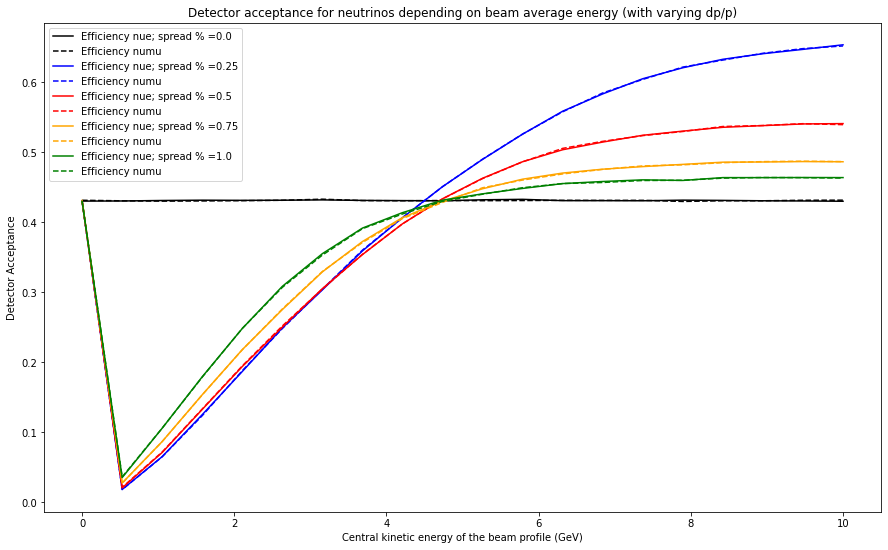

In [36]:
plt.figure(figsize=(15,9))
lines = ['black', 'blue', 'red', 'orange', 'green']
for j, c in enumerate(lines):
    plt.plot(Emu, acceptances[j][0], color=c,label='Efficiency nue; spread % ={}'.format(spreads[j]))
    plt.plot(Emu, acceptances[j][1], linestyle='dashed', color=c, label='Efficiency numu')
plt.legend()
plt.title('Detector acceptance for neutrinos depending on beam average energy (with varying dp/p)')
plt.xlabel("Central kinetic energy of the beam profile (GeV)")
plt.ylabel("Detector Acceptance")

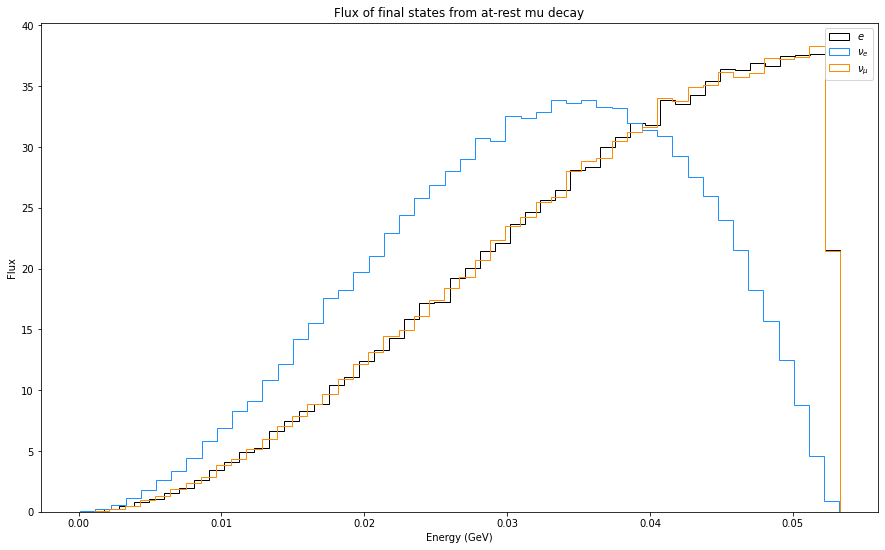

In [39]:
fig, ax = plt.subplots(figsize=(15,9))
num_bins = 50
_ = ax.hist(df['P_decay_e','0'], weights=df['w_flux'], bins=num_bins, density=True, histtype='step', lw=1, color='black', label=r'$e$')
_ = ax.hist(df['P_decay_nu_e','0'], weights=df['w_flux'], bins=num_bins, density=True, histtype='step', lw=1, color='dodgerblue', label=r'$\nu_e$')
_ = ax.hist(df['P_decay_nu_mu','0'], weights=df['w_flux'], bins=num_bins, density=True, histtype='step', lw=1, color='darkorange', label=r'$\nu_\mu$')

ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Flux')
ax.set_title('Flux of final states from at-rest mu decay')
ax.legend()
fig.savefig('plots/flux_histogram.png', dpi=300, bbox_inches='tight')


## Test 2

Now let's repeat it with a real muon beam

In [40]:
mudecay_beam = nuflux.fluxMC.MuonDecay()

df = mudecay_beam.simulate_decays(
                            pmin = 0,
                            pmax = 10,
                            beam_p0 = 3.8,
                            beam_dpop = 0.1,
                            Rpm=0.5,
                            NINT=10,
                            NINT_warmup=10,
                            NEVAL=1e5,
                            NEVAL_warmup=1e4,
                            )
_ = mudecay_beam.propagate_to_detector(
                            ZBEAMEND=250e2, # cm
                            ZBEAMEXIT=0, # cm
                            R_ND=[0,0,250e2+50e2], # cm
                            )
_ = mudecay_beam.flux_in_detector()

Detector acceptance: 0.3746532795189331  for nue, and 0.37504277186989105 for numu.


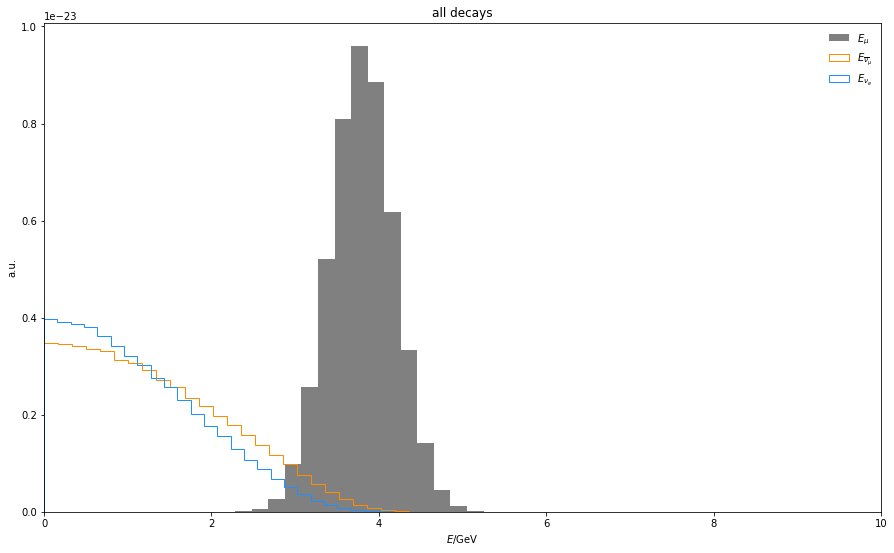

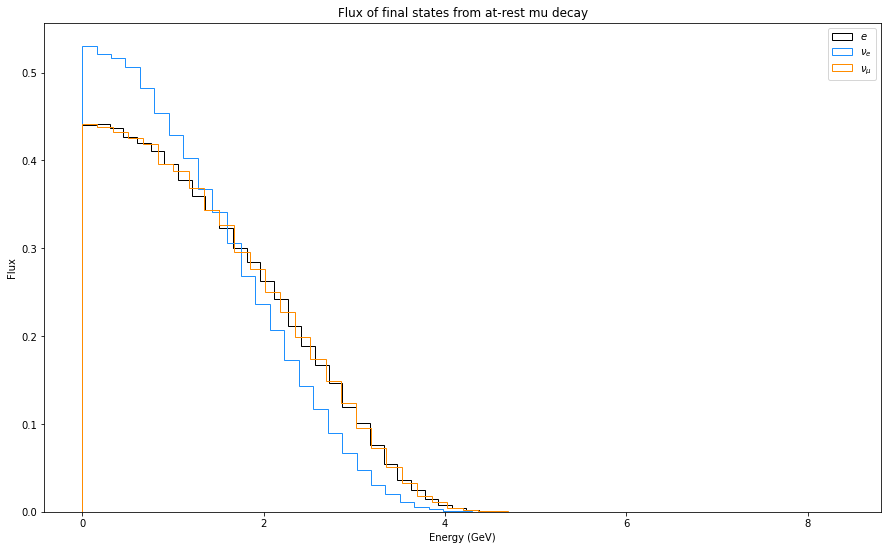

In [41]:
fig, ax = plt.subplots(figsize=(15,9))

n_bins = 50
ax.hist(mudecay_beam.Emu, weights=mudecay_beam.w, bins=n_bins, label=r'$E_\mu$',color='grey', histtype='stepfilled')
ax.hist(mudecay_beam.Enumu, weights=mudecay_beam.w, bins=n_bins, label=r'$E_{\overline{\nu}_\mu}$',color='darkorange', histtype='step')
ax.hist(mudecay_beam.Enue, weights=mudecay_beam.w, bins=n_bins, label=r'$E_{\nu_e}$',color='dodgerblue', histtype='step')

plt.legend(frameon=False,loc='upper right')
ax.set_xlim(0,10)
ax.set_ylabel(r'a.u.')
ax.set_xlabel(r'$E/$GeV')
ax.set_title(r'all decays')

fig.savefig('plots/true_flux.png', dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(15,9))
num_bins = 50
_ = ax.hist(df['P_decay_e','0'], weights=df['w_flux'], bins=num_bins, density=True, histtype='step', lw=1, color='black', label=r'$e$')
_ = ax.hist(df['P_decay_nu_e','0'], weights=df['w_flux'], bins=num_bins, density=True, histtype='step', lw=1, color='dodgerblue', label=r'$\nu_e$')
_ = ax.hist(df['P_decay_nu_mu','0'], weights=df['w_flux'], bins=num_bins, density=True, histtype='step', lw=1, color='darkorange', label=r'$\nu_\mu$')

ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Flux')
ax.set_title('Flux of final states from at-rest mu decay')
ax.legend()
fig.savefig('plots/flux_histogram.png', dpi=300, bbox_inches='tight')

Detector acceptance: 0.37538700508171396  for nue, and 0.3749409239329987 for numu.
Detector acceptance: 0.4967835531861762  for nue, and 0.49466742665358715 for numu.
Detector acceptance: 0.6167763963746066  for nue, and 0.6161884800867348 for numu.


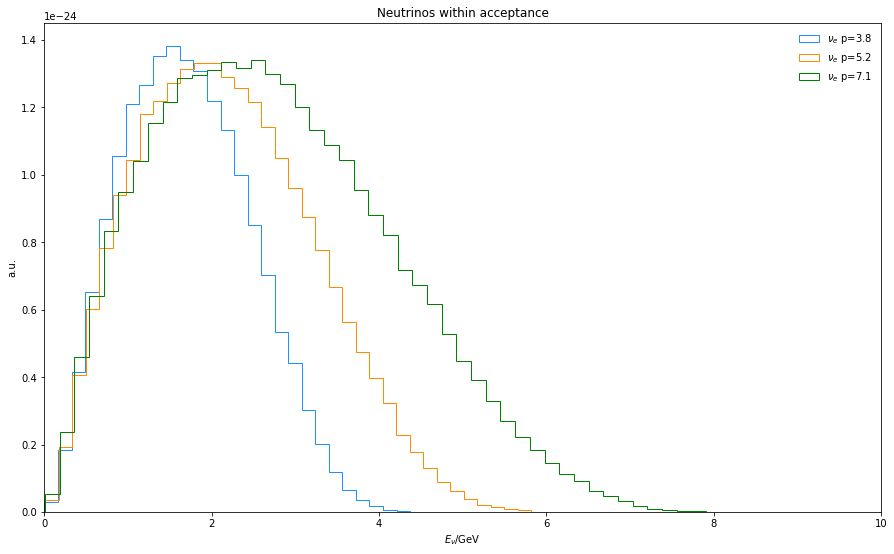

In [56]:
fig, ax = plt.subplots(figsize=(15,9))

mudecay_beam1 = nuflux.fluxMC.MuonDecay()

df = mudecay_beam1.simulate_decays(
                            pmin = 0,
                            pmax = 10,
                            beam_p0 = 3.8,
                            beam_dpop = 0.1,
                            Rpm=0.5,
                            NINT=10,
                            NINT_warmup=10,
                            NEVAL=1e5,
                            NEVAL_warmup=1e4,
                            )
_ = mudecay_beam1.propagate_to_detector(
                            ZBEAMEND=250e2, # cm
                            ZBEAMEXIT=0, # cm
                            R_ND=[0,0,250e2+50e2], # cm
                            )
_ = mudecay_beam1.flux_in_detector()

n_bins = 50
ax.hist(mudecay_beam1.Enue[mudecay_beam1.mask_nue], weights=mudecay_beam1.w[mudecay_beam1.mask_nue], bins=n_bins, label=r'$\nu_e$ p=3.8',color='dodgerblue', histtype='step')
#ax.hist(mudecay_beam1.Enumu[mudecay_beam1.mask_numu], weights=mudecay_beam1.w[mudecay_beam1.mask_numu], bins=n_bins, label=r'$\nu_\mu$ p=3.8',linestyle = 'dashed', color='dodgerblue', histtype='step')

mudecay_beam2 = nuflux.fluxMC.MuonDecay()

df = mudecay_beam2.simulate_decays(
                            pmin = 0,
                            pmax = 10,
                            beam_p0 = 5.2,
                            beam_dpop = 0.1,
                            Rpm=0.5,
                            NINT=10,
                            NINT_warmup=10,
                            NEVAL=1e5,
                            NEVAL_warmup=1e4,
                            )
_ = mudecay_beam2.propagate_to_detector(
                            ZBEAMEND=250e2, # cm
                            ZBEAMEXIT=0, # cm
                            R_ND=[0,0,250e2+50e2], # cm
                            )
_ = mudecay_beam2.flux_in_detector()

n_bins = 50
ax.hist(mudecay_beam2.Enue[mudecay_beam2.mask_nue], weights=mudecay_beam2.w[mudecay_beam2.mask_nue], bins=n_bins, label=r'$\nu_e$ p=5.2',color='darkorange', histtype='step')
#ax.hist(mudecay_beam2.Enumu[mudecay_beam2.mask_numu], weights=mudecay_beam2.w[mudecay_beam2.mask_numu], bins=n_bins, label=r'$\nu_\mu$ p=5.2',linestyle = 'dashed', color='darkorange', histtype='step')

mudecay_beam = nuflux.fluxMC.MuonDecay()

df = mudecay_beam.simulate_decays(
                            pmin = 0,
                            pmax = 10,
                            beam_p0 = 7.1,
                            beam_dpop = 0.1,
                            Rpm=0.5,
                            NINT=10,
                            NINT_warmup=10,
                            NEVAL=1e5,
                            NEVAL_warmup=1e4,
                            )
_ = mudecay_beam.propagate_to_detector(
                            ZBEAMEND=250e2, # cm
                            ZBEAMEXIT=0, # cm
                            R_ND=[0,0,250e2+50e2], # cm
                            )
_ = mudecay_beam.flux_in_detector()

n_bins = 50
ax.hist(mudecay_beam.Enue[mudecay_beam.mask_nue], weights=mudecay_beam.w[mudecay_beam.mask_nue], bins=n_bins, label=r'$\nu_e$ p=7.1',color='green', histtype='step')
#ax.hist(mudecay_beam.Enumu[mudecay_beam.mask_numu], weights=mudecay_beam.w[mudecay_beam.mask_numu], bins=n_bins, label=r'$\nu_\mu$ p=7.1',linestyle = 'dashed', color='green', histtype='step')


ax.legend(frameon=False,loc='upper right')
ax.set_xlim(0,10)
ax.set_ylabel(r'a.u.')
ax.set_xlabel(r'$E_{\nu}/$GeV')

ax.set_title(r'Neutrinos within acceptance')

fig.savefig('plots/nu_fluxes.png', dpi=300, bbox_inches='tight')

## get nu CC xsecs used in GLOBES

In [201]:
from scipy import interpolate

log10E,sigmae,sigmamu,_,sigmaebar,sigmamubar,_ = np.genfromtxt('xsecs/XCC.dat',unpack=True)
exs = 10**(log10E)
sigmanue = interpolate.interp1d(exs,sigmae*exs*1e-38,bounds_error=False,fill_value=0.0)
sigmanuebar = interpolate.interp1d(exs,sigmaebar*exs*1e-38,bounds_error=False,fill_value=0.0)
sigmanumu = interpolate.interp1d(exs,sigmamu*exs*1e-38,bounds_error=False,fill_value=0.0)
sigmanumubar = interpolate.interp1d(exs,sigmamubar*exs*1e-38,bounds_error=False,fill_value=0.0)

## Number of events

In [202]:
Detmass = 1e6 # g
Ntargets=dn.const.NAvo*Detmass
nevents_nue=mudecay_beam.flux_nue_ND*sigmanue(mudecay_beam.Enue_ND)*Ntargets/(mudecay_beam.Enue_ND[1]-mudecay_beam.Enue_ND[0])
nevents_numu=mudecay_beam.flux_numu_ND*sigmanumubar(mudecay_beam.Enumu_ND)*Ntargets/(mudecay_beam.Enumu_ND[1]-mudecay_beam.Enumu_ND[0])

In [203]:
# Event rate
Ntot_nue = np.sum(nevents_nue)
Ntot_numu = np.sum(nevents_numu)

print(Ntot_nue)
print(Ntot_numu)

6310757.390735747
2902466.266546023


# Fluxes

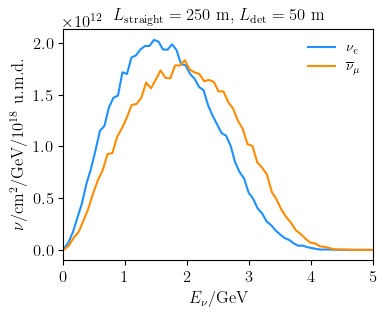

In [206]:
fig, ax = plt.subplots(figsize=(4,3))

ax.plot(mudecay_beam.Enue_ND,mudecay_beam.flux_nue_ND,label=r'$\nu_e$',color='dodgerblue')
ax.plot(mudecay_beam.Enumu_ND,mudecay_beam.flux_numu_ND,label=r'$\overline{\nu}_\mu$',color='darkorange')

ax.legend(frameon=False,loc='upper right')
ax.set_xlim(0,5)
ax.set_ylabel(r'$\nu$/cm$^2$/GeV/$10^{18}$ u.m.d.')
ax.set_xlabel(r'$E_{\nu}/$GeV')

ax.set_title(r'$L_{\rm straight} = 250$~m, $L_{\rm det} = 50$~m ',fontsize=fsize)
# ax.set_yscale('log'),
# ax.set_ylim(1e9,1e12)
fig.savefig('plots/nu_fluxes_smooth.png', dpi=300, bbox_inches='tight')

# N events

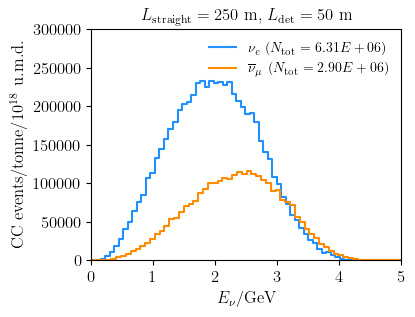

In [207]:
fig, ax = plt.subplots(figsize=(4,3))

ax.step(mudecay_beam.Enue_ND,nevents_nue,label=fr'$\nu_e$ ($N_{{\rm tot}} = {Ntot_nue:.2E}$)',color='dodgerblue')
ax.step(mudecay_beam.Enumu_ND,nevents_numu,label=fr'$\overline{{\nu}}_\mu$ ($N_{{\rm tot}} = {Ntot_numu:.2E}$)',color='darkorange')


ax.legend(frameon=False,loc='upper right')
ax.set_xlim(0,5)
ax.set_ylim(0,3e5)
ax.set_ylabel(r'CC events/tonne/$10^{18}$ u.m.d.')
ax.set_xlabel(r'$E_{\nu}/$GeV')

ax.set_title(r'$L_{\rm straight} = 250$~m, $L_{\rm det} = 50$~m ',fontsize=fsize)

fig.savefig('plots/nu_events.png', dpi=300, bbox_inches='tight')